In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('dataset_clean.csv')

df["failure_probability"] = (
    df["failure_probability"] - df["failure_probability"].min()
) / (df["failure_probability"].max() - df["failure_probability"].min())


features = df[['sessions_7d', 'errors_7d', 'no_session_days', 'failure_rate_7d']]
target = df['failure_probability']


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)


X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).permute(0,2,1)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).permute(0,2,1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64)


class SimpleTCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleTCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.tcn(x).squeeze(-1)
        return self.fc(x)

model = SimpleTCN(input_dim=4, hidden_dim=32, output_dim=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


history = []

model.train()
for epoch in range(10):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_loader)
    history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

# Courbe de la perte
plt.figure(figsize=(8,4))
plt.plot(range(1, len(history)+1), history, marker='o', color='green')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.title('Évolution de la perte lors de l\'entraînement')
plt.grid(True)
plt.show()

# Évaluation rapide
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print("Test Loss:", test_loss.item())


Epoch 1, Loss: 0.5763249335167914
Epoch 2, Loss: 0.5756191498776332
Epoch 3, Loss: 0.5754253234241735
Epoch 4, Loss: 0.5753284061673822
Epoch 5, Loss: 0.5752691863580498
Epoch 6, Loss: 0.575264814617576
Epoch 7, Loss: 0.5753059437983568
Epoch 8, Loss: 0.5752746986543533
Epoch 9, Loss: 0.5752692370078312
Epoch 10, Loss: 0.5752302840005347
Test Loss: 0.5728094577789307


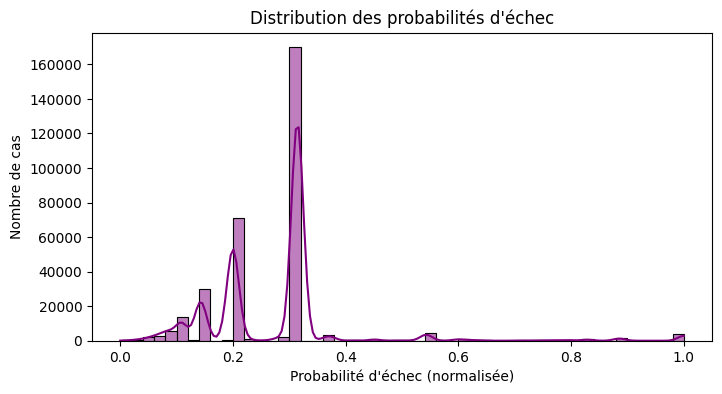

In [6]:
# Distribution propre de la target
plt.figure(figsize=(8, 4))
sns.histplot(df["failure_probability"], bins=50, kde=True, color='purple')
plt.title("Distribution des probabilités d'échec")
plt.xlabel("Probabilité d'échec (normalisée)")
plt.ylabel("Nombre de cas")
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

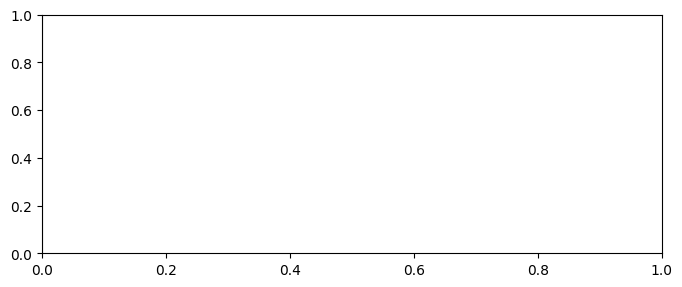

In [8]:
import shap

# Préparation de l'explication SHAP rapide
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:100])

# Plot d'importance SHAP
shap.summary_plot(shap_values, features=X_test[:100].numpy(), feature_names=['sessions_7d', 'errors_7d', 'no_session_days', 'failure_rate_7d'])

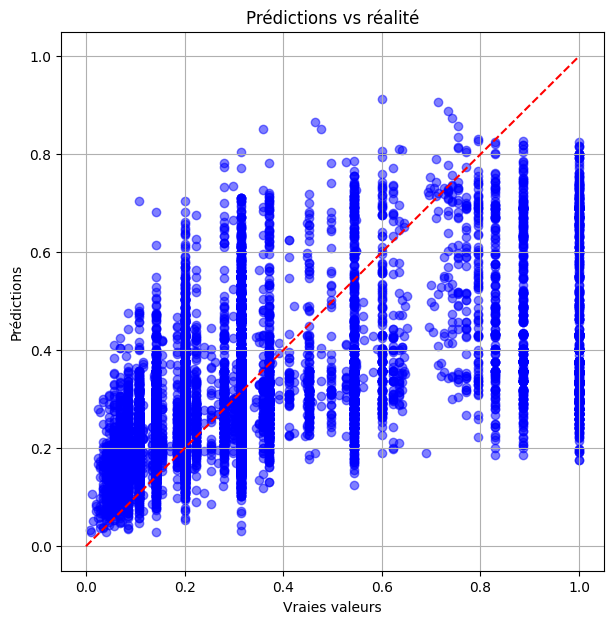

In [9]:
# Scatter plot des prédictions vs réalité
plt.figure(figsize=(7,7))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([0,1],[0,1], color='red', linestyle='--') # diagonale parfaite
plt.title("Prédictions vs réalité")
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.grid(True)
plt.show()